# Pruebas de estrés desde la perspectiva de los sistemas lineales e invariantes en el tiempo

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Agosto 2020 · 5 min read

---

## Resumen

Las pruebas de rendimiento de software son útiles para determinar si un sistema es capaz de procesar suficientes cantidades de información sin caerse o realentizarse. Ejemplos de sistemas que requieren hacer este tipo de pruebas son las páginas web de los bancos o de los sitios de comercio electrónico, donde un retraso en el despliegue de la información puede traducirse en pérdida de clientes. En este ipython notebook estudiamos un tipo de prueba de rendimiento llamada "pruebas de estrés" que tiene como objetivo encontrar el punto de quiebre, es decir, el máximo número de transacciones por segundo que el sistema es capaz de procesar antes de caerse. A diferencia del resto de artículos, nuestro enfoque se dedica a la parte del modelado matemático y sistemas lineales e invariantes en el tiempo (LTI, por sus siglas en Inglés), en lugar de explicar las herramientas de software existentes para este tipo de pruebas. Se identificaron dos modelos para simular el procesamiento del sistema ante una entrada en forma de rampa, pero, se determinó que los servidores web no cumplen con la definición de un sistema lineal e invariante en el tiempo.

# 1 Pruebas de estrés

Una prueba de estrés tiene como objetivo encontrar el punto de quiebre, es decir, el maximo número de transacciones por segundo que el sistema es capaz de procesar antes de caerse [1]. Para encontrar este valor se utiliza un enfoque iterativo que incrementa linealmente en el número del número de transacciones por segundo para monitorear el número de errores por segundo y los tiempos de respuesta. El número de transacciones por segundo también es llamado _usuarios virtuales por segundo_ (o VU/s, por sus siglas en inglés) y gráficamente se ve así:

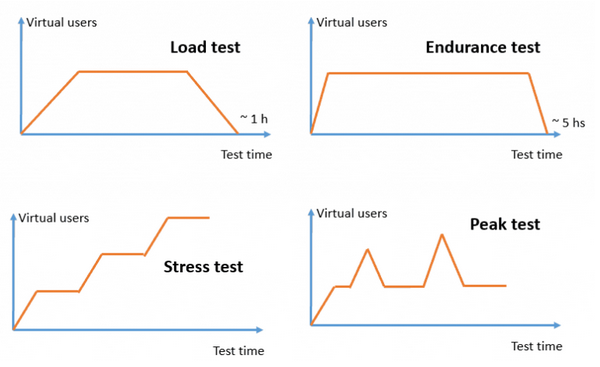

Figura 1. Imágen tomada sin permiso de https://abstracta.us/wp-content/uploads/2015/10/why-perf-testing-is-nec-chart-768x463.png.

Esta forma escalonada de la función de usuarios virtuales por segundo puede representarse como una rampa descrita por la ecuación:

$$
x[n]= \frac{dx[n]}{dn} n u[n],\qquad(1)
$$

donde $0<\frac{dx[n]}{dn}$ es la tasa de cambio (VU por segundo) y $u[n]$ es la función de Heaviside o escalón unitario (1 cuando $0 \le n$, 0 en el resto). Tomando $N=100$ como la duración del experiento podemos hacer:

Populating the interactive namespace from numpy and matplotlib


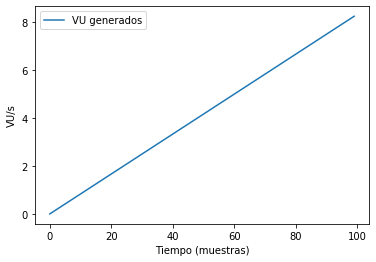

In [3]:
%pylab inline
import numpy as np

pylab.plot(5/60*np.arange(0,100),label='VU generados')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

El número de usuarios virtuales por segundo se relaciona con otra curva llamada _ancho de banda del sistema_ (_throughput_, en Inglés), que representa la capacidad del servidor a través del tiempo. Esta curva es linealmente creciente en los primeros instantes, pues entre más se le exige al sistema más capacidad mostrará, y luego se comporta de forma constante, cuando llega al punto de quiebre. Para modelarla, podemos tomar la ecuación (1) y hacer $\frac{dx[n]}{dn}=\frac{q}{n_0}$, como sigue:

$$
x[n] = \frac{q}{n_0} n u[n],
$$

y luego definir la respuesta del sistema a la rampa:

$$
y[n] = \min(x[n], q),\qquad(2)
$$

donde $0<q$ es el punto de quiebre y $n_0$ el instante donde ocurre. Tomando $q=5$ y $n_0=60$ podemos ver el siguiente gráfico:

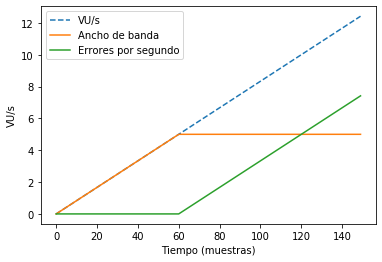

In [4]:
N = 150 # duracion del experimento (en numero de muestras)
n0 = 60 # instante del punto de quiebre (en numero de muestras)
q = 5.0 # punto de quiebre (en usuarios virtuales por segundo)1
n = np.arange(0,N)
x = q/n0 * n

def respuestaRampa(x):
    N = len(x)
    y = np.zeros(N)
    for n in range(1,N):
        y[n] = np.min([x[n], q])
    return y

y = respuestaRampa(x)
e = x-y
pylab.plot(x,'--',label='VU/s')
pylab.plot(y,label='Ancho de banda')
pylab.plot(e,label='Errores por segundo')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

Después de haber transcurrido $n_0$ muestras, la respuesta del sistema se aplana como es esperado y la cantidad de errores aumenta proporcionalmente al número de transacciones no procesadas. Este número de errores por segundo es también otra medida de interés y se calcula como $e[n] = x[n] - y[n]$, la diferencia entre el número de usuarios por segundo y el ancho de banda del sistema. Los errores en un servidor web corresponden a solicitudes con códido de respuesta 500, como lo define el _protocolo de transferencia de hipertexto_ (HTTP, por sus siglas en Inglés). 

De la cantidad de errores por segundo y la cantidad de usuarios virtuales por segundo es posible definir otra medida llamada _tasa de error_, calculada como: 

$$
    E[n]=e[n]/x[n].
$$ 

Esta medida permite identificar cuando el sistema se cuentra estresado, porque si $\frac{dE[n]}{dn} \propto \frac{dx[n]}{dn}$ significa que la cantidad de errores incrementa proporcionalmente a la cantidad de usuarios virtuales por segundo y el sistema está ignorando las solicitudes de los usuarios que superan el punto de quiebre, como se observa a continuación después del instante $n_0$:

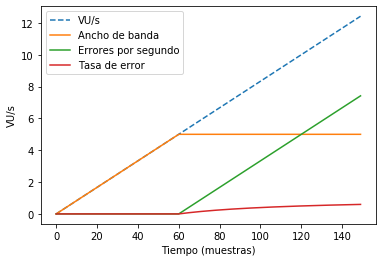

In [5]:
E = e/(x+1e-16)
pylab.plot(x,'--',label='VU/s')
pylab.plot(y,label='Ancho de banda')
pylab.plot(e,label='Errores por segundo')
pylab.plot(E,label='Tasa de error')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

Hay otra medida más llamada la _curva de retrasos_ o _tiempos de respuesta_, que representa el tiempo que requiere el servidor para completar una solicitud. Es de esperar que los tiempos de respuesta aumenten entre más usuarios deba procesar el sistema, porque hay una competencia de recursos computacionales.

Encontrar las cuatro curvas mencionadas hasta ahora es, en esencia, el objetivo de las pruebas de estrés. Conociendo cuál es el punto de quiebre del sistema se puede comparar esta cantidad con el número de usuarios por segundo que se espera atender en el ambiente de producción, e incrementar los recursos del sistema si es necesario. 

Cabe mencionar que existe otra forma de estresar el sistema que consiste en quitar temporalmente del servidor recursos de memoria, capacidad de procesamiento o ancho de banda. Por ejemplo, cuando ser quiere saber cómo reaccionará un balanceador de carga cuando uno de sus servidores se reinicie en media tarea de procesamiento [8]. 

# 2 Probando un sitio web

Teniendo una idea de qué es una prueba de estrés, podemos estudiar el comportamiento de un sistema real a modo de ejemplo. Para ello escogimos una página web llamada [bloodpressurepulse.herokuapp.com](https://bloodpressurepulse.herokuapp.com/xxyn4pz8yhb0i7n) dedicada a la visualización de datos. El sitio web toma archivos CSV almacenados en la nube y genera gráficos interactivos usando Python Dash. Un vistazo de la interfaz principal se observa en la figura 2.

![imagen.png](img/sitioWeb.png)
Figura 2. Pantallazo del sitio web.

Como explicamos en la sección anterior, hay varias formas de estresar una página web, y en este ejemplo elegimos incrementar el número de usuario por segundo en lugar de introducir archivos CSV cada vez más grandes.

Empezamos por definir los parámetros del tiempo de rampa (_ramp-up period_) y el total de usuarios que necesita la herramienta JMeter:
* **Tiempo de rampa (TR):** 60 segundos.
* **Total de usuarios:** 30 (i.e. el acumulado de usuarios o $\sum_{n=0}^{\text{TR}}{x[n]}$).

El tiempo de rampa es equivalente a nuestro parámetro $N$ de la sección 1, y esta medida, junto con el total de usuarios define la pendiente de la curva de usuarios por segundo. Ambos parámetros se introducen a la herramienta JMeter para iniciar la prueba. Esta aplicación fue escogida por ser gratuita y de amplio uso en la industria, aunque hay otras aplicaciones pagas, como Blaze Meter o Load Ninja, con mejores interfaces gráficas. El código de la solución puede encontrarse en [este enlace](https://github.com/juanfonsecasolis/juanfonsecasolis.github.io/blob/master/src/bloodpressurepulse.jmx) y las figuras 3-5 muestran los resultados obtenidos.

![](img/rampa/bytesThroughputOverTime.png)
Figura 3. Ancho de banda para una señal de entrada en forma de rampa.

![](img/rampa/responseTimesOverTime.png)
Figura 4. Tiempos de respuesta para una señal de entrada en forma de rampa.

![](img/rampa/resultsInTable.png)
Figura 5. Solicitudes exitosas vs. fallidas para una señal de entrada en forma de rampa.

La figura 3 muestra que, salvo algunos picos aislados, la forma obtenido del ancho de banda se asemeja a la de nuestro modelado de la sección 1, y que los tiempos de respuesta obedecen a un comportamiento casi exponencial. La figura 5 muestra también que el punto de quiebre se alcanzó a los 10 VU/s. 

# 3 ¿Son los servidores web sistemas LTI?

Habiendo visto la teoría básica de las pruebas de estrés y habiendo ejecutado un ejemplo en un sitio real es momento de ver si podemos refinar nuestro modelo matemático. Para ello nos preguntamos si es posible predecir el comportamiento del sistema procesando otro tipo de entradas, por ejemplo, un trapezio como el que muestra la figura 1 para las pruebas de carga. Para ello, acudimos a un tipo de sistemas llamados _sistemas lineales e invariantes en el tiempo_ (LTI, por sus siglas en Inglés) que permiten caracterizar completamente el comportamiento de un sistema midiendo su respuesta al impulso. Para que un sistema sea LTI es necesario determinar si un cumple con las siguientes dos condiciones [3]:
1. Cumplir con el principio de superposición: $T(\alpha{x_1}+\beta{x_2}) = \alpha{T(x_1)}+\beta{T(x_2)}$ (escalamiento y aditividad).
2. Ser invariante en el tiempo.

Empezamos tomando la ecuación 2 y calculando el resultado del operador $T$ ($T=y[n]$) del lado izquierdo y derecho de la condición 1. A modo de simplicación hacemos $\alpha=\beta=1$ y $x_1[n]=x_2[n]=q$, como sigue:

$$
T(x_1[n]+x_2[n]) = \min(x_1[n]+x_2[n], q) = \min(2q,q) = q,
$$

$$
T(x_1[n])+T(x_2[n]) = \min(x_1[n], q) + \min(x_2[n], q) = \min(q,q) + \min(q, q) = 2q.
$$

Observamos de inmediato que la ecuación 2 no cumple la propiedad de aditividad porque $T(x_1[n]+x_2[n]) \neq T(x_1[n])+T(x_2[n])$, por lo tanto el sistema no es LTI, y no hace falta demostrar la condición de invarianza en el tiempo. La condición 1 se puede interpretar como que la salida tiene que ser proporcional a la entrada, por lo tanto, una entrada pequeña da como resultado una salida pequeña y viceversa, pero nuestro sentido común y la experiencia nos dice que el sistema no da más después de haber alcanzado su capacidad máxima.

Es importante destacar que el tipo de modelo afecta la calidad de las estimaciones porque también pudimos haber usado $y[n] = x[n] - x[n-n_0]$, en lugar de la ecuación 2, y con esto haber obtenido un sistema LTI (se deja al lector el ejercicio de demostrarlo), pero este modelo no sería acorde a la realidad como observamos a continuacion:

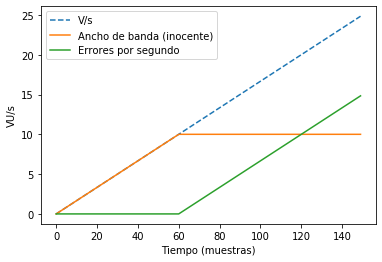

In [6]:
def respuestaRampaInocente(x, n0):
    N = len(x)
    y = np.zeros(N)
    for n in range(1,N):
        y[n] = x[n] - (x[n-n0] if 0<=n-n0 else 0)
    return y

y = respuestaRampaInocente(2*x,n0)
pylab.plot(2*x,'--',label='V/s')
pylab.plot(y,label='Ancho de banda (inocente)')
pylab.plot(2*x-y,label='Errores por segundo')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

Aca el haber procesado la entrada $x[n] =  2 \frac{q}{n_0} n u(n)$ habría duplicado la capacidad del sistema, lo cual es falso con recursos computacionales limitados. Como no es posible modelar un servidor web mediante un sistema LTI es necesario acudir a otras técnicas de modelado no lineales [6,7].

# Conclusiones

Las pruebas de estrés consisten en caracterizar el comportamiento del sistema ante un número creciente de usuarios virtuales por segundo (en forma de rampa) o una cantidad mayor de datos, utilizando recursos finitos o menos recursos computacionales que de costumbre. Este tipo de pruebas permite encontrar cuatro curvas llamadas: ancho de banda, errores por segundo, tasa de errores, y tiempos de respuesta. La ecuación $y[n] = \min(x[n], q)$ es un modelo válido que permite representar el comportamiento del sistema antes y después del llegar al punto de quiebre. Esta ecuación permitió determinar además que los servidores web no son sistemas lineales e invariantes en el tiempo porque tienen una capacidad limitada de procesamiento y su salida no varía proporcionalmente a la entrada. Es necesario estudiar técnicas de modelado no lineal para simular la salidad del sistema ante entradas usadas en otro tipo de pruebas, por ejemplo, entradas de forma trapezoidal empleadas en las pruebas de carga.

# Referencias
1. Pruebas de rendimiento del software. (2020, 11 de abril). Wikipedia, La enciclopedia libre. Fecha de consulta: 01:24, agosto 23, 2020 desde https://es.wikipedia.org/w/index.php?title=Pruebas_de_rendimiento_del_software&oldid=125096412. 
2. JMeter. (2020, 9 de enero). Wikipedia, La enciclopedia libre. Fecha de consulta: 02:28, agosto 23, 2020 desde https://es.wikipedia.org/w/index.php?title=JMeter&oldid=122610309.
3. Delta de Dirac. (2020, 10 de junio). Wikipedia, La enciclopedia libre. Fecha de consulta: 22:56, agosto 23, 2020 desde https://es.wikipedia.org/w/index.php?title=Delta_de_Dirac&oldid=126816207. 
4. Convolución. (2020, 24 de mayo). Wikipedia, La enciclopedia libre. Fecha de consulta: 01:36, agosto 24, 2020 desde https://es.wikipedia.org/w/index.php?title=Convoluci%C3%B3n&oldid=126349064. 
5. Respuesta a impulso. (2020, 12 de enero). Wikipedia, La enciclopedia libre. Fecha de consulta: 02:45, agosto 24, 2020 desde https://es.wikipedia.org/w/index.php?title=Respuesta_a_impulso&oldid=122700886. 
6. Sistema no lineal. (2020, 13 de abril). Wikipedia, La enciclopedia libre. Fecha de consulta: 04:02, agosto 28, 2020 desde https://es.wikipedia.org/w/index.php?title=Sistema_no_lineal&oldid=125141877. 
7. Wikipedia contributors. (2020, February 21). Non-linear multi-dimensional signal processing. In Wikipedia, The Free Encyclopedia. Retrieved 04:02, August 28, 2020, from https://en.wikipedia.org/w/index.php?title=Non-linear_multi-dimensional_signal_processing&oldid=941976954 
8. Balance de carga. (2020, 5 de mayo). Wikipedia, La enciclopedia libre. Fecha de consulta: 21:42, agosto 29, 2020 desde https://es.wikipedia.org/w/index.php?title=Balance_de_carga&oldid=125804878. 

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2020,
  author = {Juan M. Fonseca-Solís},
  title = { Pruebas de estrés desde la perspectiva de los sistemas lineales e invariantes en el tiempo},
  year = 2020,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.pruebasRendimiento.html},
  urldate = {}
}
```